# K means, Gaussian mixture model and Expectation Maximization

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import multivariate_normal

In [2]:
def minkowski_mat(x,Y,p=2):
    return (np.sum((np.abs(x-Y))**p,axis=1))**(1.0/p)

In [3]:
#Code from https://stackoverflow.com/questions/12301071/multidimensional-confidence-intervals
from matplotlib.patches import Ellipse

def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip

## K means model

In [4]:
class kmeans_model:
    def __init__(self, K):
        self.K = K
    
    def train(self, traindata):
        self.Z = np.zeros((traindata.shape[0], self.K))
        
        #Initialize the means randomly
        inds = range(self.Z.shape[0])
        random.shuffle(inds)
        self.mus = np.array(traindata[inds[:4]])
        
        obj_f_delta = 10000.0
        total_dist = 0
        old_total_dist = 0

        #Run until convergence
        while obj_f_delta > 0.0:    
            #Re-populate Z
            for (i_iter, x) in enumerate(traindata):
                self.Z[i_iter] = 0.0
                self.Z[i_iter][np.argmin(minkowski_mat(x, self.mus))] = 1.0

            #Update mus
            self.mus = self.Z.T.dot(traindata)
            sums = np.array([np.sum(self.Z, axis=0),]).T
            self.mus = self.mus/sums

            old_total_dist = total_dist

            #Calculate the objective function 
            total_dist = 0

            for (i_iter, x) in enumerate(traindata):
                dist = self.Z[i_iter]*minkowski_mat(x, self.mus)
                total_dist+= np.sum(dist)

            obj_f_delta = abs(total_dist - old_total_dist)
        
        self.distortion_measure = total_dist
        

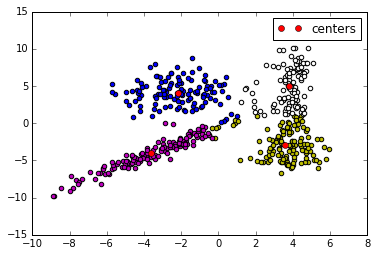

Trial 1 -----------------------------------
Means: [[ 3.80280826  5.10467248]
 [ 3.36449672 -2.65646983]
 [-3.78479953 -4.21639713]
 [-2.23856221  4.16339661]]
Objective value: 1108.46460651
Trial 2 -----------------------------------
Means: [[-2.14180002  3.97338429]
 [ 3.78809286  4.99905357]
 [ 3.60401871 -2.88772669]
 [-3.69444515 -4.16827091]]
Objective value: 1103.49615041
Trial 3 -----------------------------------
Means: [[-3.6366214  -4.05302194]
 [ 3.60401871 -2.88772669]
 [-2.1554649   4.11299388]
 [ 3.78809286  4.99905357]]
Objective value: 1102.54586111
Trial 4 -----------------------------------
Means: [[-3.72020481 -4.1849974 ]
 [ 3.78809286  4.99905357]
 [ 3.57429183 -2.880828  ]
 [-2.14180002  3.97338429]]
Objective value: 1103.9226925
Trial 5 -----------------------------------
Means: [[ 3.48330393 -2.84991997]
 [ 3.78809286  4.99905357]
 [-3.79520578 -4.24816219]
 [-2.14180002  3.97338429]]
Objective value: 1105.67929089


In [5]:
traindata = np.loadtxt('EMGaussian.train') 

kmeans = kmeans_model(4)
kmeans.train(traindata)

plt.figure()
plt.scatter(traindata[np.argwhere(kmeans.Z[:, 0]), 0], traindata[np.argwhere(kmeans.Z[:, 0]), 1], c='y')
plt.scatter(traindata[np.argwhere(kmeans.Z[:, 1]), 0], traindata[np.argwhere(kmeans.Z[:, 1]), 1], c='b')
plt.scatter(traindata[np.argwhere(kmeans.Z[:, 2]), 0], traindata[np.argwhere(kmeans.Z[:, 2]), 1], c='w')
plt.scatter(traindata[np.argwhere(kmeans.Z[:, 3]), 0], traindata[np.argwhere(kmeans.Z[:, 3]), 1], c='m')
pts_center, = plt.plot(kmeans.mus[:, 0], kmeans.mus[:, 1], 'ro', label='centers')
plt.legend(handles=[pts_center], loc=1)  
plt.show()

for i in range(5):
    print 'Trial {} -----------------------------------'.format(i+1)
    kmeans = kmeans_model(4)
    kmeans.train(traindata)
    print 'Means:', kmeans.mus
    print 'Objective value:', kmeans.distortion_measure
    

## Gaussian Mixture Model

In [6]:
def isotropic_gaussian(x, mu, variance):
    exponent = np.sum(-(x - mu)**2.0/(2.0*variance))
    denominator = (np.sqrt(variance)**x.shape[0])*((2.0*np.pi)**(x.shape[0]/2.0))
    return np.exp(exponent)/denominator

def do_E_step(K, data, pis, mus, variances):
    result = np.zeros((data.shape[0], K))
    
    for (i, x) in enumerate(data):                   
        result[i] = [pis[j]*multivariate_normal.pdf(x, mus[j], variances[j]) for j in range(K)]
        result[i] = result[i]/sum(result[i])

    return result

def calculate_likelihood(Z, K, data, pis, mus, variances):
    result = np.sum(Z*np.log(pis))

    for (i, x) in enumerate(data):                           
        result += np.sum(Z[i]*[np.log(multivariate_normal.pdf(x, mus[j], variances[j])) for j in range(K)])
    
    return result

In [7]:
class gm_model:
    def __init__(self, K, cov_type='isotropic'):
        self.K = K
        self.cov_type = cov_type
    
    def train(self, traindata):
        kmeans = kmeans_model(self.K)
        kmeans.train(traindata)
        #Initialize means to kmeans
        self.mus = kmeans.mus
        
        if (self.cov_type == 'isotropic'):
            self.variance = np.ones(self.K)*10.0
        else:
            self.variance = [np.array([[10, 5], [5, 10]]) for i in range(self.K)]
            
        self.pis = [float(np.size(np.argwhere(kmeans.Z[:, i])))/kmeans.Z.shape[0] for i in range(self.K)]
        self.Z = np.zeros((traindata.shape[0], self.K))

        delta = 1000
        prev_likelihood = 0
        self.likelihood = 0
        
        while (abs(delta) > (10**-5)):
            ############### E-step ###############
            self.Z = do_E_step(self.K, traindata, self.pis, self.mus, self.variance)
            
            ############### M-step ###############

            #Bernoulli parameters
            self.pis = [np.sum(self.Z[:, j])/self.Z.shape[0] for j in range(self.K)]

            #Means
            self.mus = self.Z.T.dot(traindata)/np.array([np.sum(self.Z, axis=0),]).T

            if (self.cov_type == 'isotropic'):
                self.variance = [np.sum(self.Z[:, j].T.dot((traindata - self.mus[j])**2))/(np.sum(self.Z, axis=0)[j]*traindata.shape[1]) for j in range(self.K)]
            else:
                #is there a way without a double loop?
                for j in range(self.K):
                    self.variance[j] = np.zeros((traindata.shape[1], traindata.shape[1]))

                    for (i, x) in enumerate(traindata): 
                        diff = np.array([x - self.mus[j],])
                        self.variance[j]+= self.Z[i,j]*diff.T.dot(diff)
                    #After summing, divide
                    self.variance[j] = self.variance[j]/np.sum(self.Z, axis=0)[j]
                
            prev_likelihood = self.likelihood

            #Calculate the likelihood
            self.likelihood = calculate_likelihood(self.Z, self.K, traindata, self.pis, self.mus, self.variance)

            delta = self.likelihood - prev_likelihood

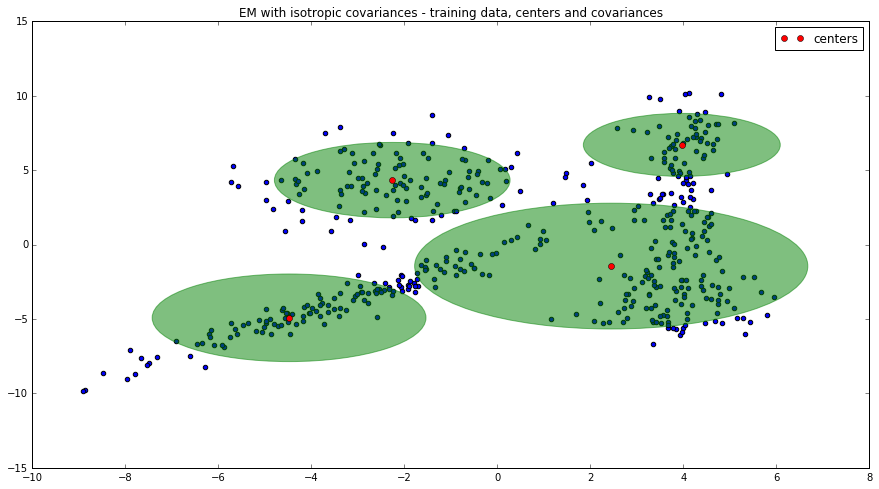

[EMGaussian.train] - Normalized log likelihood for isotropic: -5.4475222155


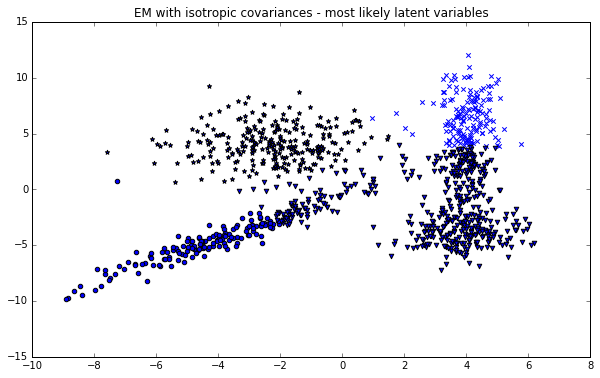

In [8]:
#initialize
K = 4
traindata = np.loadtxt('EMGaussian.train') 
iso_gm_model = gm_model(K)
iso_gm_model.train(traindata)

plt.figure(figsize=(15,8))
plt.title('EM with isotropic covariances - training data, centers and covariances')
pts_center, = plt.plot(iso_gm_model.mus[:, 0], iso_gm_model.mus[:, 1], 'ro', label='centers')
plt.scatter(traindata[:,0], traindata[:,1])

for g in range(K):
    #1.65 as standard deviation to highlight 90% of the mass of the Gaussian distribution
    plot_cov_ellipse(cov=np.identity(traindata.shape[1])*iso_gm_model.variance[g], pos=iso_gm_model.mus[g], nstd=1.65, alpha=0.5, color='green')
    
plt.legend(handles=[pts_center], loc=1)    
plt.show()

Z_train_iso = do_E_step(K, traindata, iso_gm_model.pis, iso_gm_model.mus, iso_gm_model.variance)
iso_train_likelihood = calculate_likelihood(Z_train_iso, K, traindata, iso_gm_model.pis, iso_gm_model.mus, iso_gm_model.variance)

print '[EMGaussian.train] - Normalized log likelihood for isotropic: {}'.format(iso_train_likelihood/traindata.shape[0])

################# Estimate and represent the most likely latent variables for all data points

#Estimate latent variables for isotropic gaussian
testdata = np.loadtxt('EMGaussian.test')
alldata = np.vstack((traindata, testdata))

Z_all_data_iso = do_E_step(K, alldata, iso_gm_model.pis, iso_gm_model.mus, iso_gm_model.variance)

plt.figure(figsize=(10,6))
plt.title('EM with isotropic covariances - most likely latent variables')
plt.scatter(alldata[np.argmax(Z_all_data_iso, axis=1) == 0, 0], alldata[np.argmax(Z_all_data_iso, axis=1) == 0, 1], marker='o')
plt.scatter(alldata[np.argmax(Z_all_data_iso, axis=1) == 1, 0], alldata[np.argmax(Z_all_data_iso, axis=1) == 1, 1], marker='*')
plt.scatter(alldata[np.argmax(Z_all_data_iso, axis=1) == 2, 0], alldata[np.argmax(Z_all_data_iso, axis=1) == 2, 1], marker='x')
plt.scatter(alldata[np.argmax(Z_all_data_iso, axis=1) == 3, 0], alldata[np.argmax(Z_all_data_iso, axis=1) == 3, 1], marker='v')  
plt.show()

## GMM - full covariance matrices

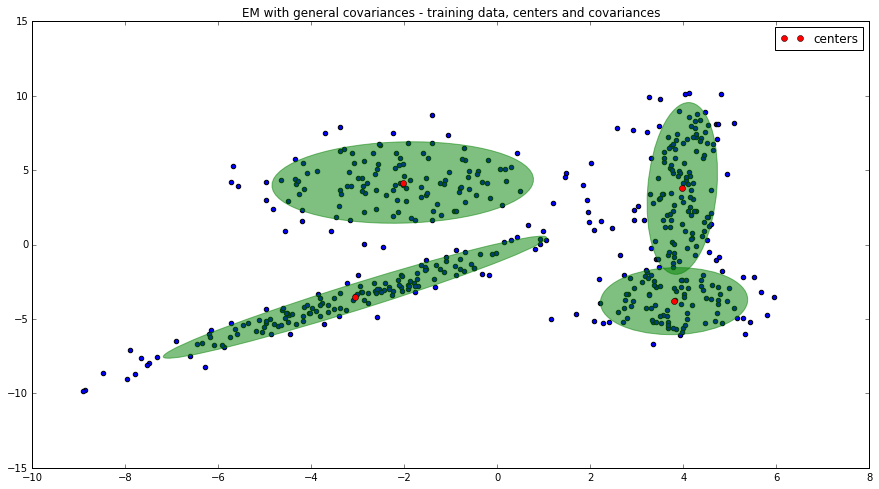

[EMGaussian.train] - Normalized log likelihood for general: -4.74176812834


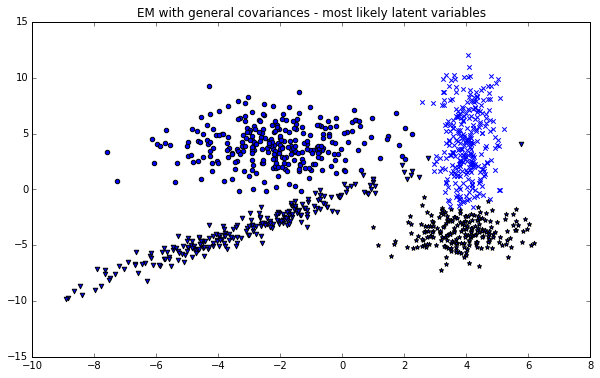

In [9]:
#initialize
K = 4
traindata = np.loadtxt('EMGaussian.train') 

full_gm_model = gm_model(K, cov_type='full')
full_gm_model.train(traindata)

plt.figure(figsize=(15,8))
plt.title('EM with general covariances - training data, centers and covariances')
plt.scatter(traindata[:,0], traindata[:,1])
pts_center, = plt.plot(full_gm_model.mus[:, 0], full_gm_model.mus[:, 1], 'ro', label='centers')

for g in range(K):
    #1.65 as standard deviation to highlight 90% of the mass of the Gaussian distribution
    plot_cov_ellipse(cov=full_gm_model.variance[g], pos=full_gm_model.mus[g], nstd=1.65, alpha=0.5, color='green')

plt.legend(handles=[pts_center], loc=1)    
plt.show()

Z_train_full = do_E_step(K, traindata, full_gm_model.pis, full_gm_model.mus, full_gm_model.variance)
full_train_likelihood = calculate_likelihood(Z_train_full, K, traindata, full_gm_model.pis, full_gm_model.mus, full_gm_model.variance)

print '[EMGaussian.train] - Normalized log likelihood for general: {}'.format(full_train_likelihood/traindata.shape[0])

################# Estimate and represent the most likely latent variables for all data points

#Estimate latent variables for general gaussian
testdata = np.loadtxt('EMGaussian.test')
alldata = np.vstack((traindata, testdata))

Z_all_data_full = do_E_step(K, alldata, full_gm_model.pis, full_gm_model.mus, full_gm_model.variance)

plt.figure(figsize=(10,6))
plt.title('EM with general covariances - most likely latent variables')
plt.scatter(alldata[np.argmax(Z_all_data_full, axis=1) == 0, 0], alldata[np.argmax(Z_all_data_full, axis=1) == 0, 1], marker='o')
plt.scatter(alldata[np.argmax(Z_all_data_full, axis=1) == 1, 0], alldata[np.argmax(Z_all_data_full, axis=1) == 1, 1], marker='*')
plt.scatter(alldata[np.argmax(Z_all_data_full, axis=1) == 2, 0], alldata[np.argmax(Z_all_data_full, axis=1) == 2, 1], marker='x')
plt.scatter(alldata[np.argmax(Z_all_data_full, axis=1) == 3, 0], alldata[np.argmax(Z_all_data_full, axis=1) == 3, 1], marker='v')  
plt.show()


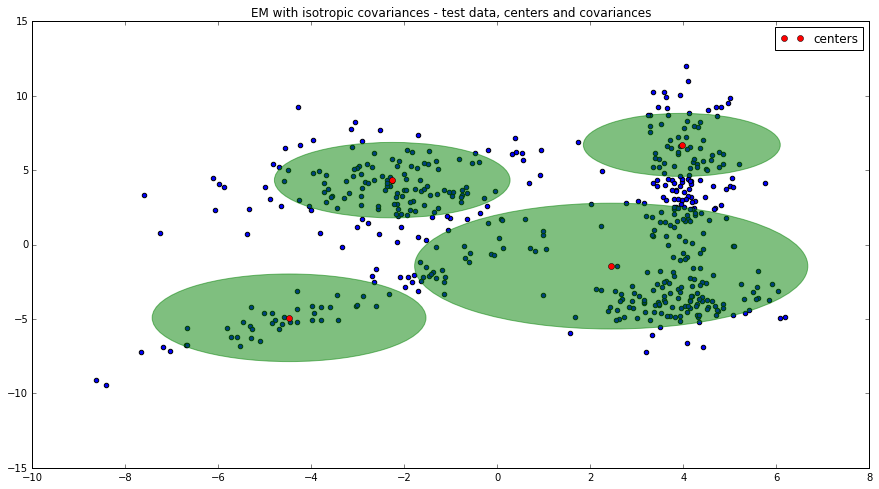

[EMGaussian.test] - Normalized log likelihood for isotropic: -5.55385954863


In [10]:
#Run the model on the test data - ISOTROPIC COVARIANCE MATRICES
filename='EMGaussian.test'
testdata = np.loadtxt(filename) 

#Estimate the latent variables for the isotropic model
Z_test_iso = do_E_step(iso_gm_model.K, testdata, iso_gm_model.pis, iso_gm_model.mus, iso_gm_model.variance)
    
iso_test_likelihood = calculate_likelihood(Z_test_iso, iso_gm_model.K, testdata, iso_gm_model.pis, iso_gm_model.mus, iso_gm_model.variance)

plt.figure(figsize=(15,8))
plt.title('EM with isotropic covariances - test data, centers and covariances')
plt.scatter(testdata[:,0], testdata[:,1])
pts_center, = plt.plot(iso_gm_model.mus[:, 0], iso_gm_model.mus[:, 1], 'ro', label='centers')

for g in range(K):
    #1.65 as standard deviation to highlight 90% of the mass of the Gaussian distribution
    plot_cov_ellipse(cov=np.identity(testdata.shape[1])*iso_gm_model.variance[g], pos=iso_gm_model.mus[g], nstd=1.65, alpha=0.5, color='green')

plt.legend(handles=[pts_center], loc=1)    
plt.show()
print '[{}] - Normalized log likelihood for isotropic: {}'.format(filename, iso_test_likelihood/testdata.shape[0])

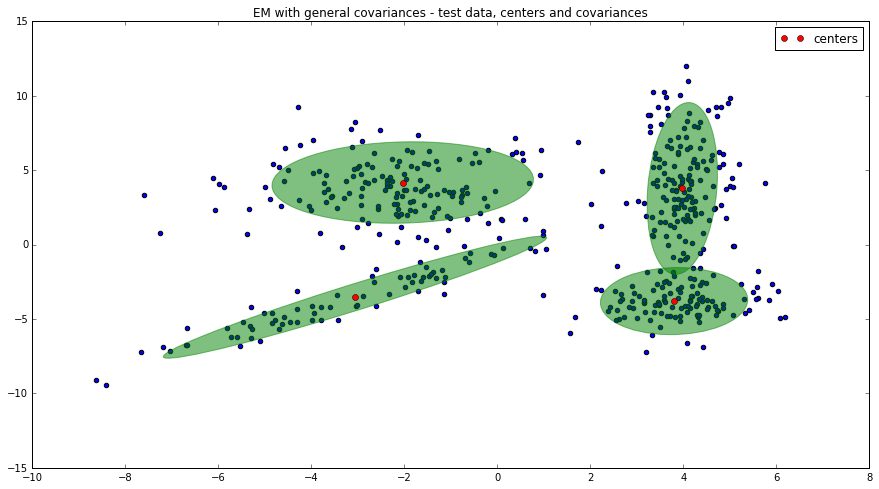

[EMGaussian.test] - Normalized log likelihood for general: -4.90712640125


In [11]:
#Run the model on the test data - GENERAL COVARIANCE MATRICES
filename='EMGaussian.test'
testdata = np.loadtxt(filename) 

#Estimate the latent variables for the general covariances model
Z_test_full = do_E_step(full_gm_model.K, testdata, full_gm_model.pis, full_gm_model.mus, full_gm_model.variance)
    
#Calculate the likelihood
full_test_likelihood = calculate_likelihood(Z_test_full, full_gm_model.K, testdata, full_gm_model.pis, full_gm_model.mus, full_gm_model.variance)

plt.figure(figsize=(15,8))
plt.title('EM with general covariances - test data, centers and covariances')
plt.scatter(testdata[:,0], testdata[:,1])  
pts_center, = plt.plot(full_gm_model.mus[:, 0], full_gm_model.mus[:, 1], 'ro', label='centers')

for g in range(K):
    #1.65 as standard deviation to highlight 90% of the mass of the Gaussian distribution
    plot_cov_ellipse(cov=full_gm_model.variance[g], pos=full_gm_model.mus[g], nstd=1.65, alpha=0.5, color='green')

plt.legend(handles=[pts_center], loc=1)    
plt.show()
print '[{}] - Normalized log likelihood for general: {}'.format(filename, full_test_likelihood/testdata.shape[0])

In [13]:
#Print learned parameters for general covariance matrices
print full_gm_model.mus
print full_gm_model.variance

[[-2.03436694  4.17258598]
 [ 3.80070942 -3.79729643]
 [ 3.97793041  3.77333362]
 [-3.06196061 -3.53454038]]
[array([[ 2.90442388,  0.2065577 ],
       [ 0.2065577 ,  2.7561708 ]]), array([[ 0.92127883,  0.05738071],
       [ 0.05738071,  1.86586224]]), array([[  0.21035657,   0.29045015],
       [  0.29045015,  12.23995238]]), array([[ 6.24140965,  6.05017515],
       [ 6.05017515,  6.18245577]])]
